In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score, log_loss

## Load & Understand data

In [2]:
from ucimlrepo import fetch_ucirepo, list_available_datasets

# check which datasets can be imported
list_available_datasets()

# import dataset
heart_disease = fetch_ucirepo(id=45)
# alternatively: fetch_ucirepo(name='Heart Disease')

# access data
X = heart_disease.data.features
y = heart_disease.data.targets
# train model e.g. sklearn.linear_model.LinearRegression().fit(X, y)

# access metadata
print(heart_disease.metadata.uci_id)
print(heart_disease.metadata.num_instances)
print(heart_disease.metadata.additional_info.summary)

# access variable info in tabular format
print(heart_disease.variables)

-------------------------------------
The following datasets are available:
-------------------------------------
Dataset Name                                                                            ID    
------------                                                                            --    
Abalone                                                                                 1     
Adult                                                                                   2     
Annealing                                                                               3     
Audiology (Standardized)                                                                8     
Auto MPG                                                                                9     
Automobile                                                                              10    
Balance Scale                                                                           12    
Balloons                       

In [3]:
# Combine features and target into a single DataFrame
data = pd.concat([X, y], axis=1)
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


* age: The age of the patient in years.

* sex: The gender of the patient (1 = male, 0 = female).

* cp: The type of chest pain (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic).

* trestbps: Resting blood pressure (in mm Hg) measured upon admission.

* chol: Serum cholesterol level (in mg/dL).

* fbs: Fasting blood sugar level (1 = >120 mg/dL, 0 = ≤120 mg/dL).

* restecg: Resting electrocardiographic results (0 = normal, 1 = ST-T wave abnormality, 2 = probable left ventricular hypertrophy).

* thalach: Maximum heart rate achieved during a stress test.

* exang: Exercise-induced angina (1 = yes, 0 = no).

* oldpeak: ST depression induced by exercise relative to rest (in mm).

* slope: The slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping).

* ca: Number of major vessels (0-3) showing blockage on fluoroscopy.

* thal: Thalassemia test result (3 = normal, 6 = fixed defect, 7 = reversible defect).

* num: Presence or absence of heart disease (0 = no disease, 1-4 = varying degrees of disease).

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [5]:
for col in data.columns:
    print(f"number of uniques of \'{col}\' is: {data[col].nunique()}")
    print(f"uniques of \'{col}\' is:\n{data[col].unique()}")
    print()
    print('*' * 50)
    print()

number of uniques of 'age' is: 41
uniques of 'age' is:
[63 67 37 41 56 62 57 53 44 52 48 54 49 64 58 60 50 66 43 40 69 59 42 55
 61 65 71 51 46 45 39 68 47 34 35 29 70 77 38 74 76]

**************************************************

number of uniques of 'sex' is: 2
uniques of 'sex' is:
[1 0]

**************************************************

number of uniques of 'cp' is: 4
uniques of 'cp' is:
[1 4 3 2]

**************************************************

number of uniques of 'trestbps' is: 50
uniques of 'trestbps' is:
[145 160 120 130 140 172 150 110 132 117 135 112 105 124 125 142 128 170
 155 104 180 138 108 134 122 115 118 100 200  94 165 102 152 101 126 174
 148 178 158 192 129 144 123 136 146 106 156 154 114 164]

**************************************************

number of uniques of 'chol' is: 152
uniques of 'chol' is:
[233 286 229 250 204 236 268 354 254 203 192 294 256 263 199 168 239 275
 266 211 283 284 224 206 219 340 226 247 167 230 335 234 177 276 353 243
 225 302 212

In [6]:
#save data in CSV file
data.to_csv('heart_disease.csv', index=False)

In [7]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [8]:
data['num'] = data['num'].where(data['num'] <= 0, 1)

In [9]:
data["num"].value_counts()

num
0    164
1    139
Name: count, dtype: int64

## EDA

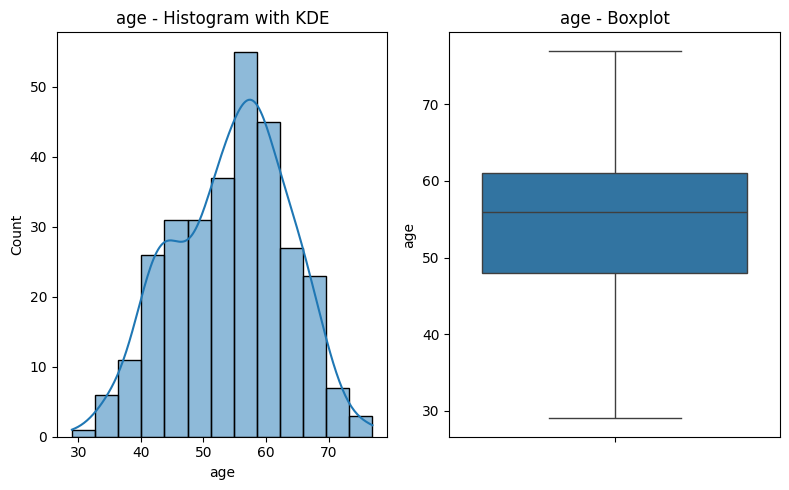

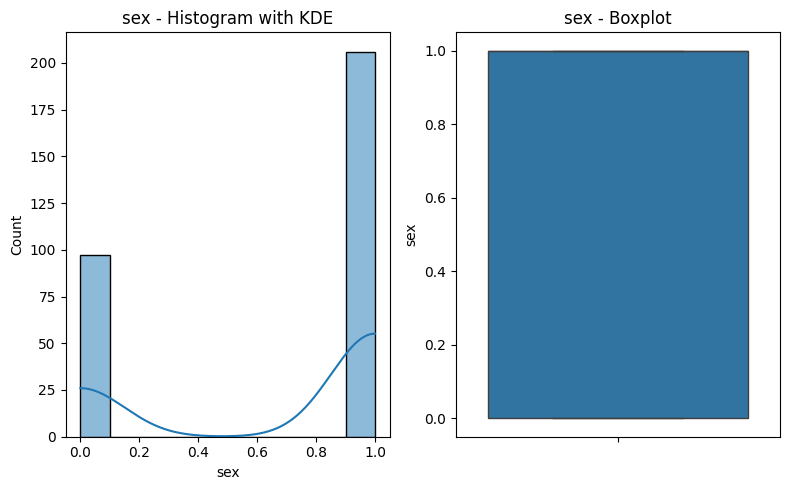

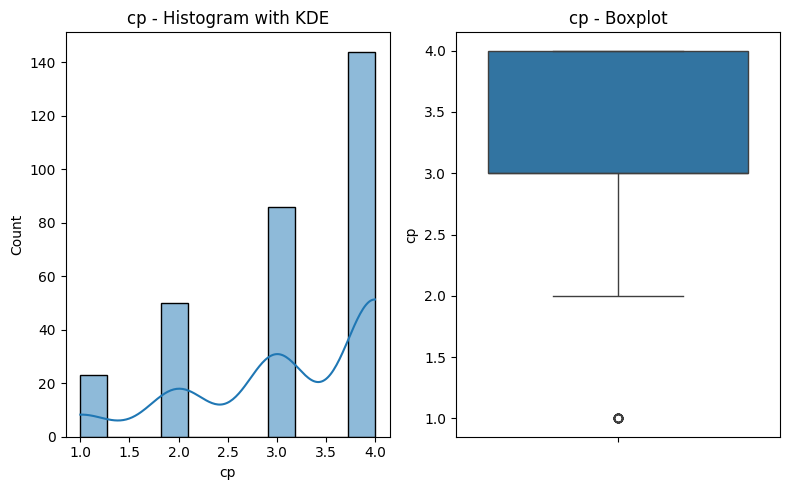

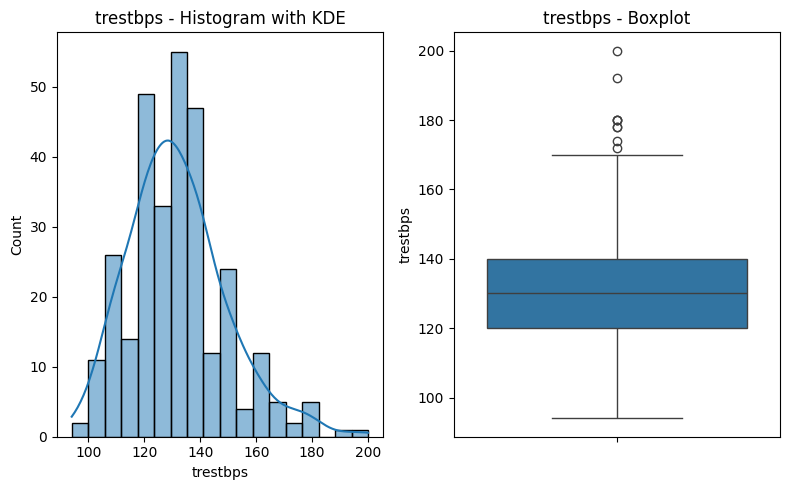

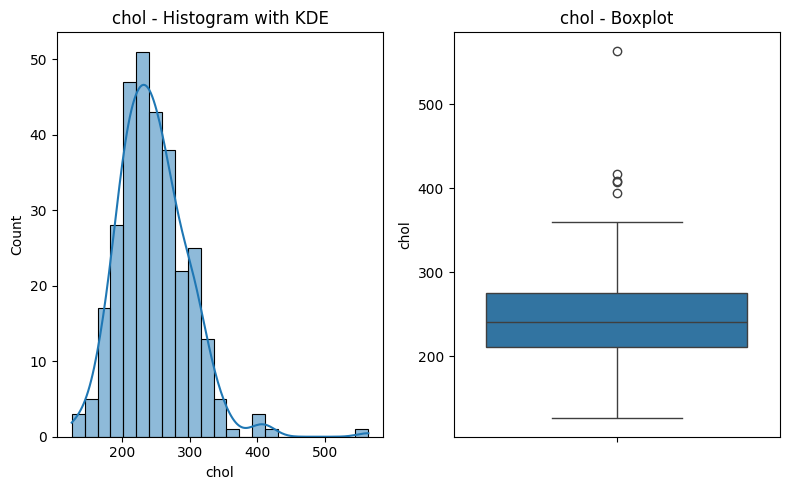

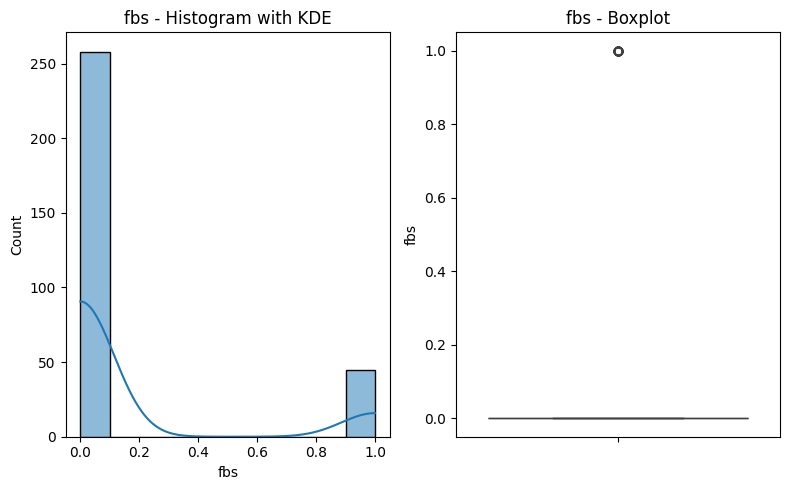

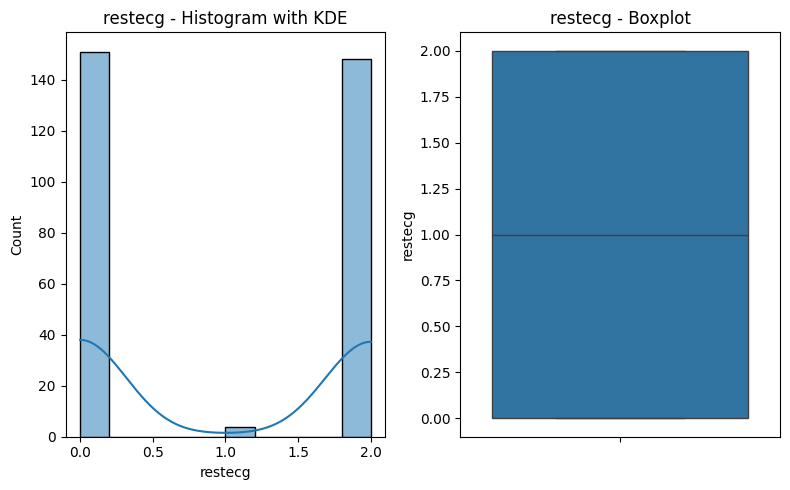

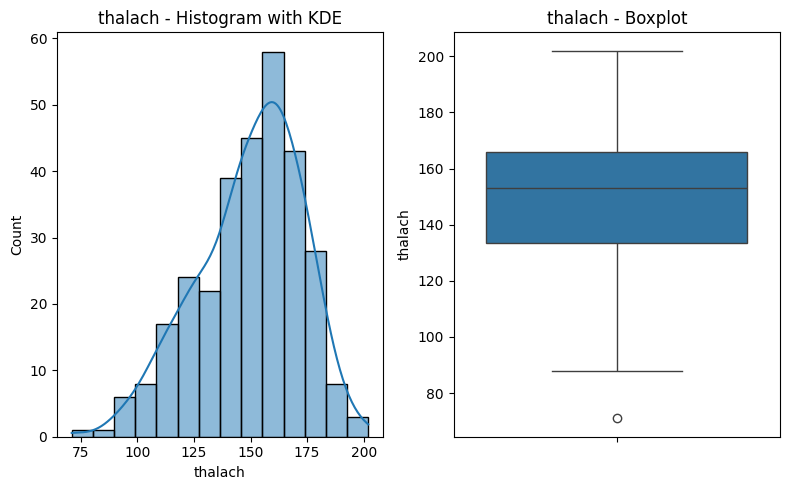

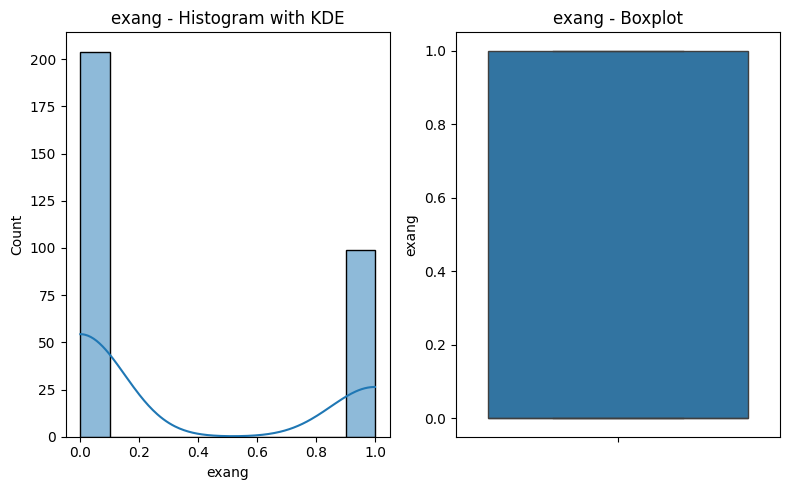

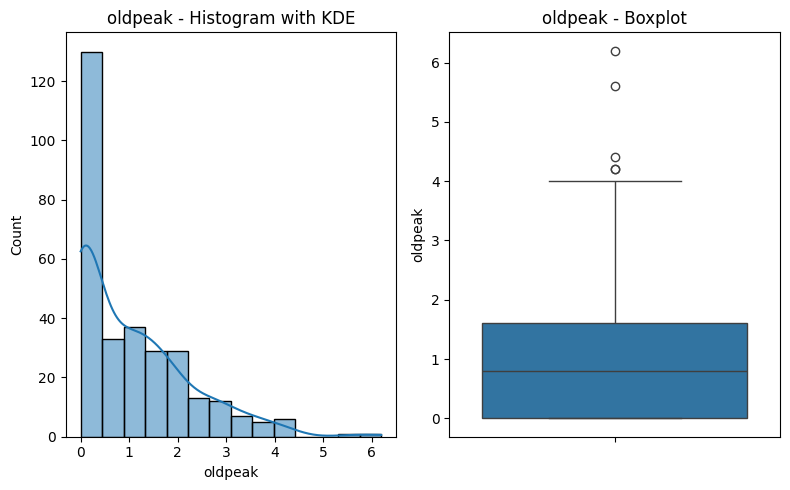

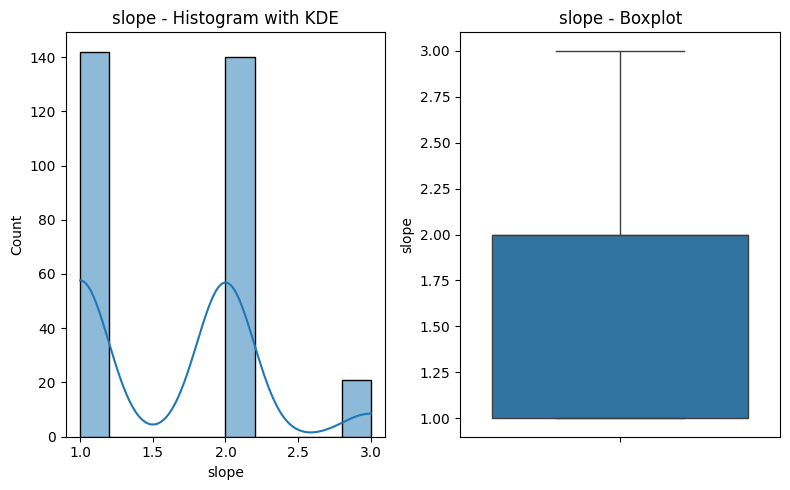

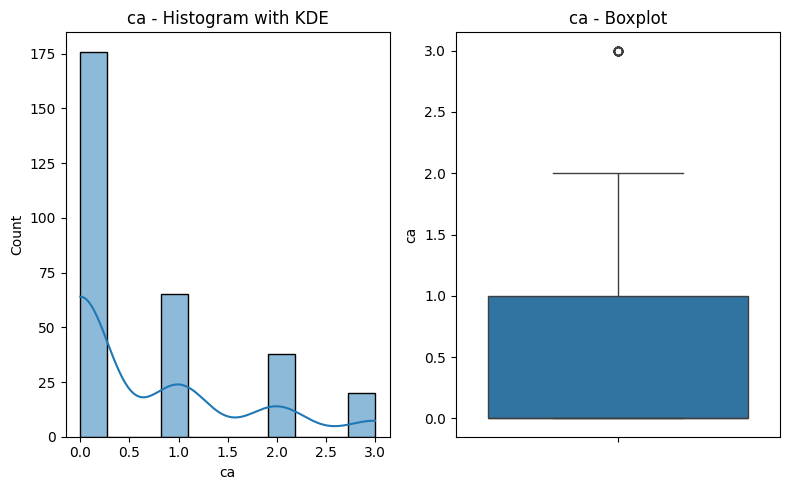

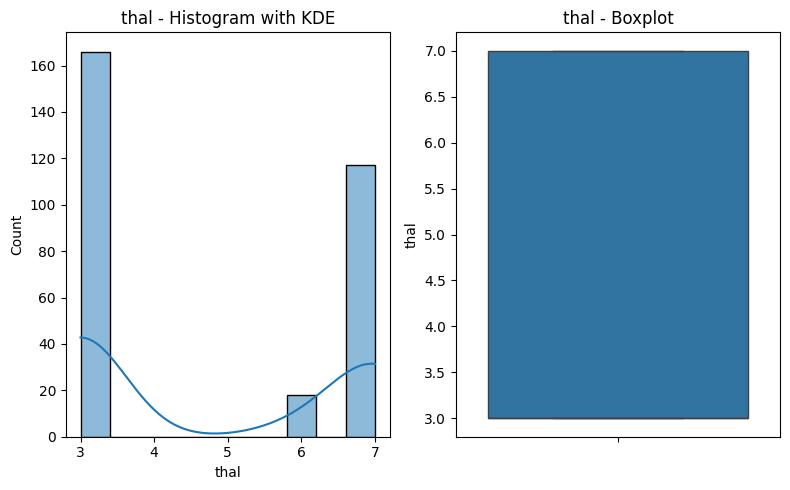

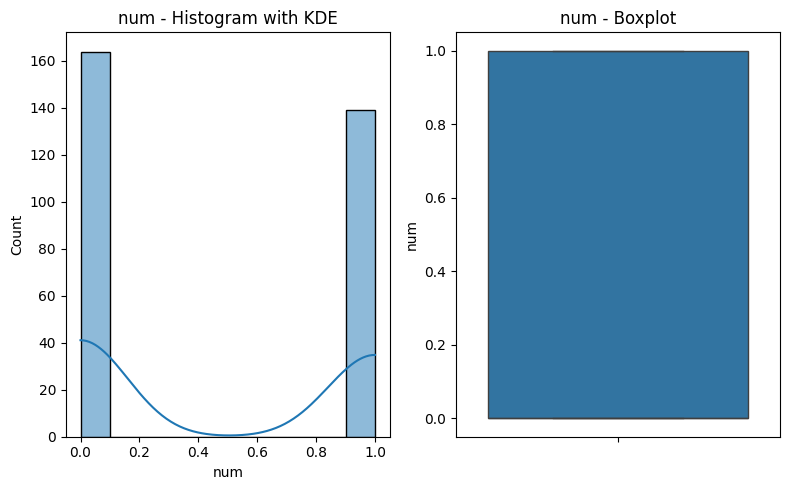

In [10]:
for col in data.columns:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,5))
    sns.histplot(data[col], kde=True, ax=axes[0])
    axes[0].set_title(f'{col} - Histogram with KDE')
    sns.boxplot(data[col], ax=axes[1])
    axes[1].set_title(f'{col} - Boxplot')
    plt.tight_layout()
    plt.show()

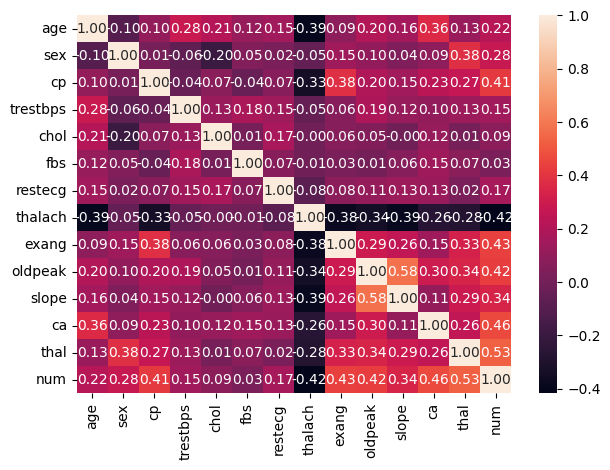

In [11]:
sns.heatmap(data.corr(), fmt=".2f", annot=True)
plt.tight_layout()

## Data Preprocessing & Cleaning 

In [12]:
data.duplicated().sum()

0

In [13]:
X = data.drop('num', axis=1)
y = data['num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train.shape, X_test.shape

((242, 13), (61, 13))

In [14]:
class Handle_outlier_lb_ub(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        q1 = np.percentile(X, 25)
        q3 = np.percentile(X, 75)
        iqr = q3 - q1
        self.ub_train = q3 + 1.5 * iqr
        self.lb_train = q1 - 1.5 * iqr
        return self
    def transform (self, X, y=None):
        assert self.n_features_in_ == X.shape[1]
        X[X > self.ub_train] = self.ub_train
        X[X < self.lb_train] = self.lb_train
        return X
h_lb_ub = Handle_outlier_lb_ub()
h_lb_ub

Handle_outlier_lb_ub()

In [15]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        return self
    
    def transform(self, X, y=None):
        assert self.n_features_in_ == X.shape[1]
        return np.log1p(X + 1)

log_transformer =LogTransformer()
log_transformer

LogTransformer()

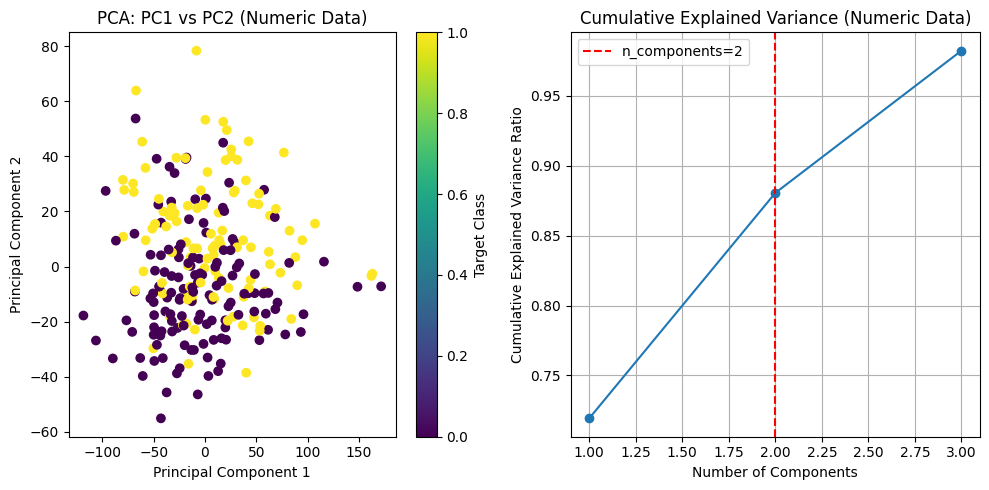

In [16]:
# Extract numeric data for PCA visualization
numeric_cols = ['trestbps', 'chol', 'oldpeak', 'age', 'thalach']
X_numeric = X_train[numeric_cols].values

# Fit PCA on numeric data for visualization
pca = PCA(n_components=3, random_state=42)
X_train_numeric_pca = pca.fit_transform(X_numeric)

# Visualize PCA results

# 1. Scatter Plot of PC1 vs PC2
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_train_numeric_pca[:, 0], X_train_numeric_pca[:, 1], c=y_train, cmap='viridis')
plt.colorbar(scatter, label='Target Class')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: PC1 vs PC2 (Numeric Data)')

# 2. Cumulative Explained Variance Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axvline(x=2, color='r', linestyle='--', label='n_components=2')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance (Numeric Data)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
# Define pipelines with consistent preprocessing & PCA steps
num_si_log_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("handle_outlier", LogTransformer()),
    ("scale", RobustScaler()),
    ("pca", PCA(n_components=2, random_state=42))  # Add PCA here
])

num_si_lb_up_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("handle_outlier", Handle_outlier_lb_ub()),
    ("scale", RobustScaler()),
    ("pca", PCA(n_components=2, random_state=42))  # Add PCA here
])

cat_knn_pipeline = Pipeline(steps=[
    ("impute", KNNImputer(n_neighbors=5))
])

In [19]:
pre_processing = ColumnTransformer(transformers=[
("num_si_log_pipeline", num_si_log_pipeline, ['trestbps', 'chol', 'oldpeak']),
("num_si_lb_up_pipeline", num_si_lb_up_pipeline, ['age', 'thalach']),
("cat_knn_pipeline", cat_knn_pipeline, ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'])
])
pre_processing

ColumnTransformer(transformers=[('num_si_log_pipeline',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('handle_outlier',
                                                  LogTransformer()),
                                                 ('scale', RobustScaler()),
                                                 ('pca',
                                                  PCA(n_components=2,
                                                      random_state=42))]),
                                 ['trestbps', 'chol', 'oldpeak']),
                                ('num_si_lb_up_pipeline',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('handle_outlier',
                                                  Handle_outlier_lb_ub()),
                                                 ('scale', RobustScaler()),
                                                 ('pca',
                                                  PCA(n_components=2,
                                                      random_state=42))]),
                                 ['age', 'thalach']),
                                ('cat_knn_pipeline',
                                 Pipeline(steps=[('impute', KNNImputer())]),
                                 ['sex', 'cp', 'fbs', 'restecg', 'exang',
                                  'slope', 'ca', 'thal'])])

In [20]:
# Apply preprocessing to training and testing features
X_train_preprocessed = pre_processing.fit_transform(X_train)
X_test_preprocessed = pre_processing.transform(X_test)

## Supervised Learning - Classification Models 

In [21]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True)
}

# Fit models and evaluate on training data
for name, model in models.items():
    model.fit(X_train_preprocessed, y_train)  # Fit model on training data
    y_train_pred = model.predict(X_train_preprocessed)  # Predict on training data
    
    # Print training accuracy and loss
    train_accuracy = model.score(X_train_preprocessed, y_train)
    train_loss = log_loss(y_train, model.predict_proba(X_train_preprocessed))
    print(f"{name} Train Accuracy: {train_accuracy:.4f}")
    print(f"{name} Train Loss: {train_loss:.4f}")

    # Cross-validation for model performance
    valid_accuracies = cross_val_score(model, X_train_preprocessed, y_train, cv=5, scoring='accuracy')
    print(f"{name} Cross-validation Accuracy scores:")
    print(pd.DataFrame(valid_accuracies).describe())
    print("\n", 50*"*")


Logistic Regression Train Accuracy: 0.8512
Logistic Regression Train Loss: 0.3533
Logistic Regression Cross-validation Accuracy scores:
              0
count  5.000000
mean   0.847109
std    0.042930
min    0.791667
25%    0.816327
50%    0.854167
75%    0.877551
max    0.895833

 **************************************************
Random Forest Train Accuracy: 1.0000
Random Forest Train Loss: 0.1147
Random Forest Cross-validation Accuracy scores:
              0
count  5.000000
mean   0.830527
std    0.030618
min    0.795918
25%    0.812500
50%    0.833333
75%    0.833333
max    0.877551

 **************************************************
XGBoost Train Accuracy: 1.0000
XGBoost Train Loss: 0.0249
XGBoost Cross-validation Accuracy scores:
              0
count  5.000000
mean   0.768793
std    0.028587
min    0.734694
25%    0.755102
50%    0.770833
75%    0.770833
max    0.812500

 **************************************************
Decision Tree Train Accuracy: 1.0000
Decision Tree Trai

In [22]:
# Initialize models and parameter grids with stricter constraints
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {'C': [0.001, 0.01, 0.1, 0.3, 1.0, 1.5, 6.0]}  # Stronger regularization
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {'C': [0.1, 0.5, 1.0, 2.0], 'kernel': ['rbf', 'linear']}  # Simpler kernel
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 120, 150, 200],
            'max_depth': [None, 3, 5, 10, 20]  # Shallower trees
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 3, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10, 15, 20]  # More samples per split
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'learning_rate': [0.01, 0.03, 0.1, 0.2],  # Lower learning rate
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [2, 3]  # Shallower trees
        }
    }
}

# Fit models with GridSearchCV and evaluate
for name, config in models.items():
    model = config['model']
    param_grid = config['params']
    
    # GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_preprocessed, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    
    # Predict on training data
    y_train_pred = best_model.predict(X_train_preprocessed)
    
    # Print training accuracy and loss
    train_accuracy = best_model.score(X_train_preprocessed, y_train)
    train_loss = log_loss(y_train, best_model.predict_proba(X_train_preprocessed))
    print(f"{name} Train Accuracy: {train_accuracy:.4f}")
    print(f"{name} Train Loss: {train_loss:.4f}")
    print(f"{name} Best Parameters: {grid_search.best_params_}")
    
    # Cross-validation for model performance
    valid_accuracies = cross_val_score(best_model, X_train_preprocessed, y_train, cv=5, scoring='accuracy')
    print(f"{name} Cross-validation Accuracy scores:")
    print(pd.DataFrame(valid_accuracies).describe())
    print("\n", 50*"*")

Logistic Regression Train Accuracy: 0.8512
Logistic Regression Train Loss: 0.3533
Logistic Regression Best Parameters: {'C': 1.0}
Logistic Regression Cross-validation Accuracy scores:
              0
count  5.000000
mean   0.847109
std    0.042930
min    0.791667
25%    0.816327
50%    0.854167
75%    0.877551
max    0.895833

 **************************************************
SVM Train Accuracy: 0.8554
SVM Train Loss: 0.3629
SVM Best Parameters: {'C': 2.0, 'kernel': 'linear'}
SVM Cross-validation Accuracy scores:
              0
count  5.000000
mean   0.842857
std    0.043256
min    0.791667
25%    0.816327
50%    0.833333
75%    0.875000
max    0.897959

 **************************************************
Random Forest Train Accuracy: 1.0000
Random Forest Train Loss: 0.1147
Random Forest Best Parameters: {'max_depth': None, 'n_estimators': 100}
Random Forest Cross-validation Accuracy scores:
              0
count  5.000000
mean   0.830527
std    0.030618
min    0.795918
25%    0.812

In [23]:
# Define SVM pipeline with best parameters
svm_pipeline = Pipeline(steps=[
    ('preprocessor', pre_processing),
    ('SVM', SVC(
        random_state=42,
        probability=True,
        C=2.0,
        kernel='linear'
    ))
])
svm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_si_log_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('handle_outlier',
                                                                   LogTransformer()),
                                                                  ('scale',
                                                                   RobustScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2,
                                                                       random_state=42))]),
                                                  ['trestbps', 'chol',
                                                   'oldpeak']),
                                                 ('num_si_lb_up_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('handle_outlier',
                                                                   Handle_outlier_lb_ub()),
                                                                  ('scale',
                                                                   RobustScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2,
                                                                       random_state=42))]),
                                                  ['age', 'thalach']),
                                                 ('cat_knn_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer())]),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'ca', 'thal'])])),
                ('SVM',
                 SVC(C=2.0, kernel='linear', probability=True,
                     random_state=42))])

In [24]:
svm_pipeline.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num_si_log_pipeline',
                                   Pipeline(steps=[('impute',
                                                    SimpleImputer(strategy='median')),
                                                   ('handle_outlier',
                                                    LogTransformer()),
                                                   ('scale', RobustScaler()),
                                                   ('pca',
                                                    PCA(n_components=2,
                                                        random_state=42))]),
                                   ['trestbps', 'chol', 'oldpeak']),
                                  ('num_si_lb_up_pipeline',
                                   Pipeline(steps=[('impute',
                                                    SimpleImputer(strategy='median')),
                                                   ('handle_outlier',


In [25]:
# Fit the pipeline including preprocessing and Logistic Regression
svm_pipeline.fit(X_train, y_train)

# Predict on training data
y_train_pred = svm_pipeline.predict(X_train)

# Print training performance metrics
train_accuracy = svm_pipeline.score(X_train, y_train)
train_loss = log_loss(y_train, svm_pipeline.predict_proba(X_train))
print(f"Logistic Regression Train Accuracy: {train_accuracy:.4f}")
print(f"Logistic Regression Train Loss: {train_loss:.4f}")

# Evaluate cross-validation scores using 5-fold CV
valid_accuracies = cross_val_score(svm_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Logistic Regression Cross-validation Accuracy scores:")
print(pd.DataFrame(valid_accuracies).describe())

Logistic Regression Train Accuracy: 0.8554
Logistic Regression Train Loss: 0.3629
Logistic Regression Cross-validation Accuracy scores:
              0
count  5.000000
mean   0.842857
std    0.043256
min    0.791667
25%    0.816327
50%    0.833333
75%    0.875000
max    0.897959


In [26]:
# Predict on test data using the trained pipeline
y_test_pred = svm_pipeline.predict(X_test)

# Print training metrics again
train_accuracy = svm_pipeline.score(X_train, y_train)
train_loss = log_loss(y_train, svm_pipeline.predict_proba(X_train))
print(f"Logistic Regression Train Accuracy: {train_accuracy:.4f}")
print(f"Logistic Regression Train Loss: {train_loss:.4f}")

print("*" * 50)

# Print test performance metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_loss = log_loss(y_test, svm_pipeline.predict_proba(X_test))
print(f"Logistic Regression Test Accuracy: {test_accuracy:.4f}")
print(f"Logistic Regression Test Loss: {test_loss:.4f}")

Logistic Regression Train Accuracy: 0.8554
Logistic Regression Train Loss: 0.3629
**************************************************
Logistic Regression Test Accuracy: 0.8852
Logistic Regression Test Loss: 0.3334


In [27]:
# Print training metrics using classification report
print("Classification Report (Train):")
print(classification_report(y_train, y_train_pred))

# Print test performance metrics using classification report
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))


Classification Report (Train):
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       135
           1       0.87      0.79      0.83       107

    accuracy                           0.86       242
   macro avg       0.86      0.85      0.85       242
weighted avg       0.86      0.86      0.85       242

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.88      0.89        32

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



In [28]:
# Compute ROC curve and AUC score for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve and AUC score for test data
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

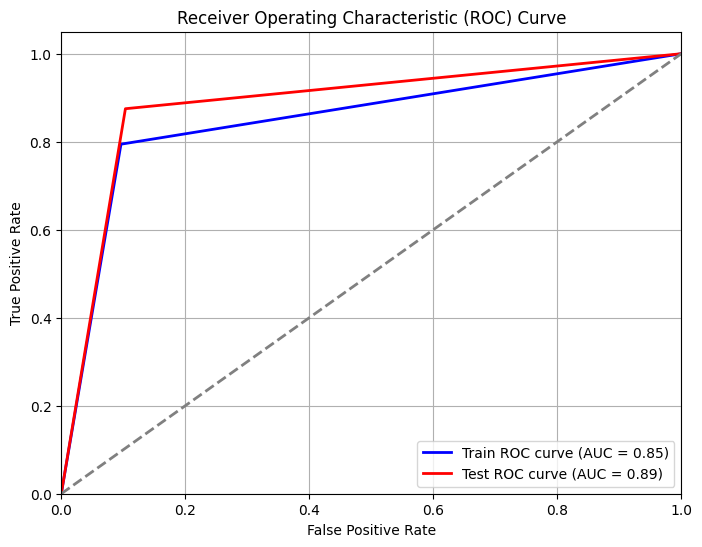

In [29]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Save the trained model

In [30]:
import pickle

# Save the model
with open('svm_pipeline_model.pkl', 'wb') as file:
    pickle.dump(svm_pipeline, file)



In [31]:
# To load the model later
with open('svm_pipeline_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
    
loaded_model.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num_si_log_pipeline',
                                   Pipeline(steps=[('impute',
                                                    SimpleImputer(strategy='median')),
                                                   ('handle_outlier',
                                                    LogTransformer()),
                                                   ('scale', RobustScaler()),
                                                   ('pca',
                                                    PCA(n_components=2,
                                                        random_state=42))]),
                                   ['trestbps', 'chol', 'oldpeak']),
                                  ('num_si_lb_up_pipeline',
                                   Pipeline(steps=[('impute',
                                                    SimpleImputer(strategy='median')),
                                                   ('handle_outlier',
